### (Optional) Install Neural A* on Colab

We highly recommend the use of GPUs for faster training/planning.

In [ ]:
!git clone --recursive https://github.com/omron-sinicx/neural-astar

In [ ]:
%cd neural-astar
!pip install -U pip setuptools
!pip install .

## Run Neural A*

In [1]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from neural_astar.planner import NeuralAstar, VanillaAstar
from neural_astar.utils.data import create_dataloader
from neural_astar.utils.training import set_global_seeds, calc_metrics_from_multiple_results, visualize_results

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/yonetani/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
neural_astar = NeuralAstar(encoder_arch='CNN').to(device)
neural_astar.load_state_dict(torch.load("model/mazes_032_moore_c8/best.pt", map_location=torch.device(device)))

vanilla_astar = VanillaAstar().to(device)

In [3]:
# average performances over 5 starts

set_global_seeds(1234)
dataloader = create_dataloader("planning-datasets/data/mpd/mazes_032_moore_c8.npz", "test", 100, shuffle=False, num_starts=5)
va_outputs_list, na_outputs_list = [], []
with torch.no_grad():
    for map_designs, start_maps, goal_maps, opt_trajs in dataloader:
        for i in tqdm(range(start_maps.shape[1])):
            vanilla_astar.eval()
            va_outputs_list.append(vanilla_astar(map_designs.to(device), start_maps[:, i:i+1].to(device), goal_maps.to(device)))
            neural_astar.eval()
            na_outputs_list.append(neural_astar(map_designs.to(device), start_maps[:, i:i+1].to(device), goal_maps.to(device)))
            
calc_metrics_from_multiple_results(na_outputs_list, va_outputs_list)

Number of Test Samples: 100
	Size: 32x32


  0%|                                                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]/home/yonetani/.venv/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


optimality: 0.788, efficiency: 0.433, h_mean: 0.506

Number of Test Samples: 100
	Size: 32x32


(-0.5, 171.5, 35.5, -0.5)

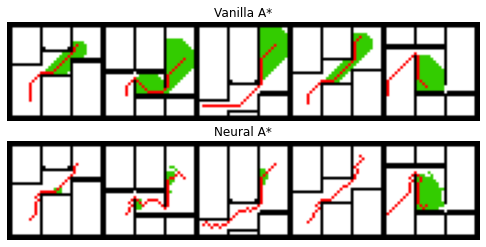

In [4]:
# Visualization

dataloader = create_dataloader("planning-datasets/data/mpd//mazes_032_moore_c8.npz", "test", 5, shuffle=False, num_starts=1)
map_designs, start_maps, goal_maps, opt_trajs = next(iter(dataloader))
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
va_outputs = vanilla_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))

plt.figure(figsize=[12, 4])
plt.subplot(2, 1, 1)
plt.imshow(visualize_results(map_designs, va_outputs))
plt.title("Vanilla A*")
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(visualize_results(map_designs, na_outputs))
plt.title("Neural A*")
plt.axis("off")


## Train Neural A*

In [6]:
# CNN encoder
!python scripts/train.py

scripts/train.py:28: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config", config_name="train")
Number of Train Samples: 800
	Size: 32x32
Number of Validation Samples: 100
	Size: 32x32
Number of Test Samples: 100
	Size: 32x32
training:   0%|                       | 0/8 [00:00<?, ?it/s]/home/yonetani/programs/omron-sinicx/neural-astar/.venv/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
training:  50%|███████▌       | 4/8 [00:07<00:07,  1.78s/it]^C
